# Avocado Prices

DataSet : https://www.kaggle.com/neuromusic/avocado-prices 

It is a well known fact that Millenials LOVE Avocado Toast. It's also a well known fact that all Millenials live in their parents basements.

Clearly, they aren't buying home because they are buying too much Avocado Toast!

But maybe there's hope… if a Millenial could find a city with cheap avocados, they could live out the Millenial American Dream.

Here we will try to compare the Linear Regression Model and SVR Model.

For us the target of this project is to predict the future price of avocados depending on some variables / features we have such as 

* Type     
* Bags(4 units) vs Bundle(one unit)     
* Region      
* Volume      
* Size     
* Years

## Column Description

* Date - The date of the observation   --> Will not be using this feature.
* AveragePrice - the average price of a single avocado    --> Target
* Total Volume - Total number of avocados sold (small Hass + Large Hass + XLarge Hass + Total Bags)
* 4046 - Total number of avocados with PLU 4046 sold  (Small Hass)
* 4225 - Total number of avocados with PLU 4225 sold  (Large Hass)
* 4770 - Total number of avocados with PLU 4770 sold  (XLarge Hass)
* Total Bags = Small Bags + Large Bags + XLarge Bags 
* type - conventional or organic
* year - the year
* Region - the city or region of the observation

# Import Library

In [154]:
# Import Library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import svm
# import decision tree regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
# import minmax scaler
from sklearn.preprocessing import MinMaxScaler
import pymongo
import pickle

# Load Data

In [155]:
df = pd.read_csv('./avocado.csv', usecols=range(1,14))

In [156]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [157]:
df.shape

(18249, 13)

# Check for Missing Data

In [158]:
df.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [159]:
# df.drop(['4046', '4225', '4770'], axis=1).head() #This is a useful function for removing any irrelivent data from the df


C## hecking  Imbalance 
## Region

In [160]:
len(df.region.unique())

54

In [161]:
df.groupby('region').size() 

region
Albany                 338
Atlanta                338
BaltimoreWashington    338
Boise                  338
Boston                 338
BuffaloRochester       338
California             338
Charlotte              338
Chicago                338
CincinnatiDayton       338
Columbus               338
DallasFtWorth          338
Denver                 338
Detroit                338
GrandRapids            338
GreatLakes             338
HarrisburgScranton     338
HartfordSpringfield    338
Houston                338
Indianapolis           338
Jacksonville           338
LasVegas               338
LosAngeles             338
Louisville             338
MiamiFtLauderdale      338
Midsouth               338
Nashville              338
NewOrleansMobile       338
NewYork                338
Northeast              338
NorthernNewEngland     338
Orlando                338
Philadelphia           338
PhoenixTucson          338
Pittsburgh             338
Plains                 338
Portland             

There are ~338 observations from each region, dataset seems balanced, and there are 54 regions.

In [162]:
df.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

In [163]:
df.duplicated().sum()

0

## The average prices by regions

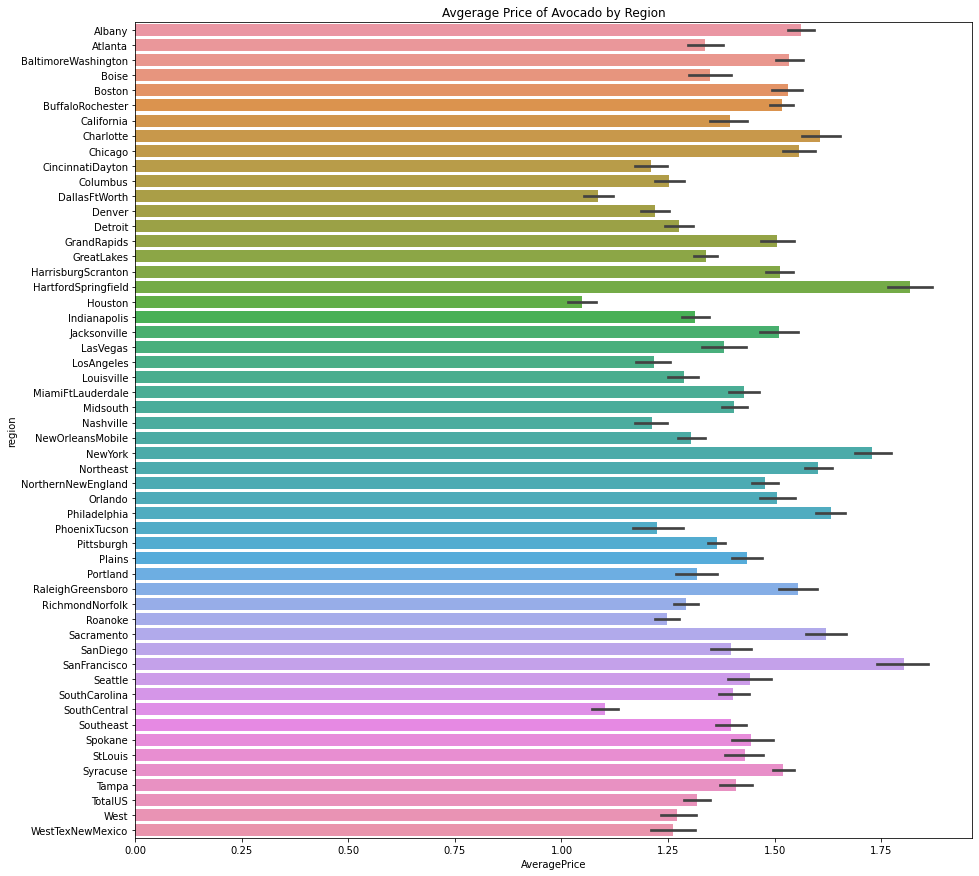

In [164]:
plt.figure(figsize=(15,15))

plt.title("Avgerage Price of Avocado by Region")

sns.barplot(x="AveragePrice",y="region",data= df)

plt.show()

Observation : Seems there are some regions which are US States (say California) and US Cities (say San Francisco) of that State or just Cities. Also there is a region as "TotalUS"; "West".

For now lets leave them as is... but we could handle them.

## type

In [165]:
print(len(df.type.unique()))

df.groupby('type').size()


2


type
conventional    9126
organic         9123
dtype: int64

## Types of avocados are also balanced since the ratio is nearly 0.5 each.

# The average prices of avocados by types 

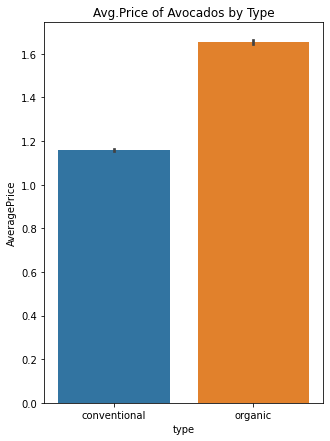

In [166]:
plt.figure(figsize=(5,7))

plt.title("Avg.Price of Avocados by Type")

sns.barplot(x="type",y="AveragePrice",data= df)

plt.show()

# Correlation

<AxesSubplot:>

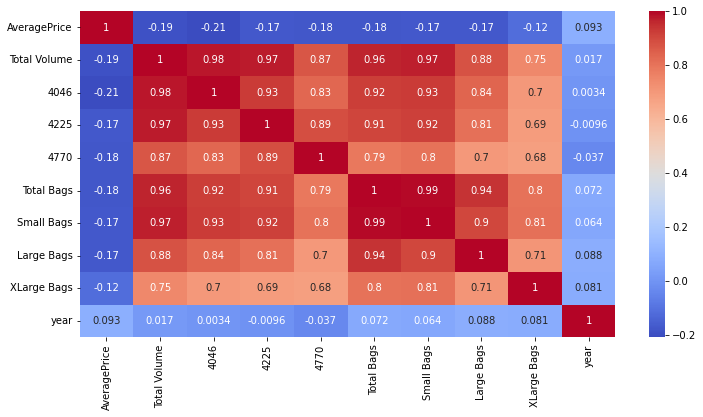

In [167]:
plt.figure(figsize=(12,6))
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)

## Observation :
There is a high correlation between pairs: 
* 4046 & total volume  (0.98)    
* 4225 & total volume  (0.97)
* 4770 & total volume  (0.87)
* total bags & total volume  (0.96)      
* small bags & total bags    (0.99) 
* etc

* `4046` avocados are the most preferred/sold type in the US and customers tend to buy those avocados as bulk, not bag.
* Retailers want to increase the sales of bagged avocados instead of bulks. They think this is more advantageous for them.
* Total Bags variable has a very high correlation with Total Volume (Total Sales) and Small Bags, so we can say that most of the bagged sales comes from the small bags.

In [168]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [153]:
df.corr()['AveragePrice'].sort_values(ascending=False)

AveragePrice    1.000000
year            0.093197
XLarge Bags    -0.117592
4225           -0.172928
Large Bags     -0.172940
Small Bags     -0.174730
Total Bags     -0.177088
4770           -0.179446
Total Volume   -0.192752
4046           -0.208317
Name: AveragePrice, dtype: float64

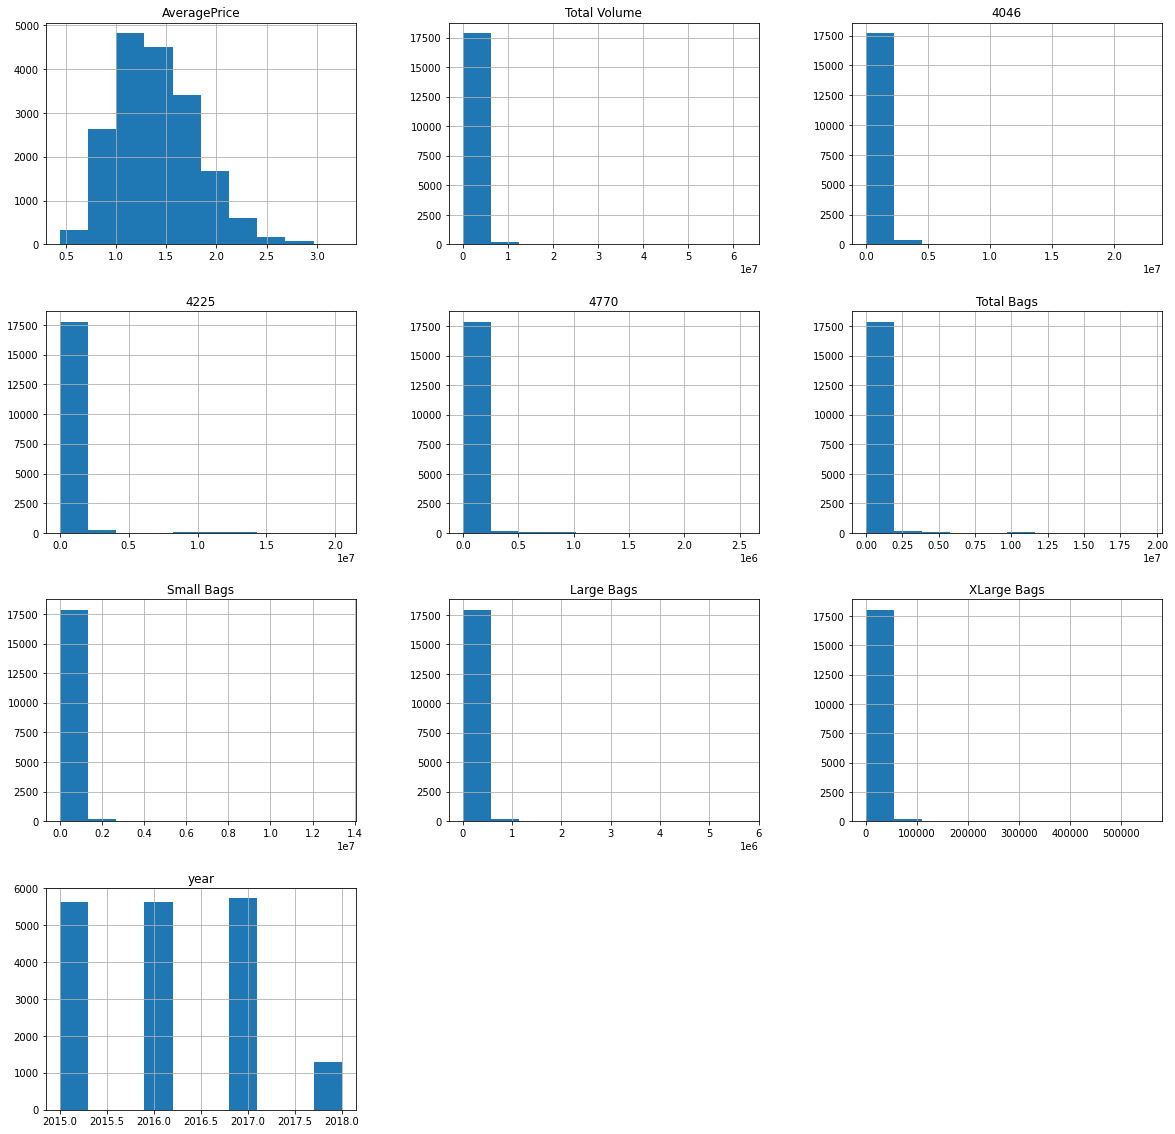

In [169]:
df.hist(figsize=(20,20))
plt.show()

In [171]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in df.columns:
    if df[col].dtype=='object':
        df[col]=le.fit_transform(df[col])

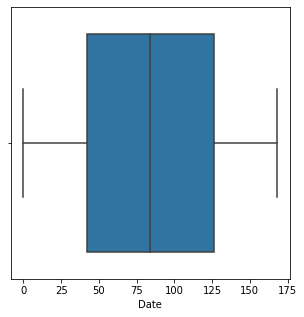

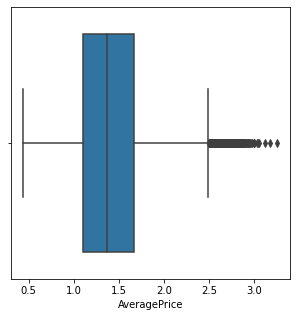

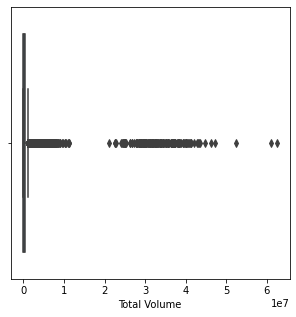

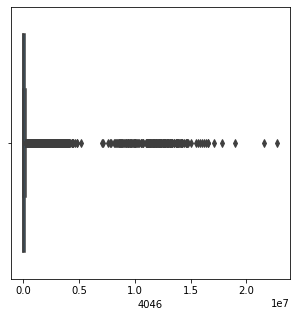

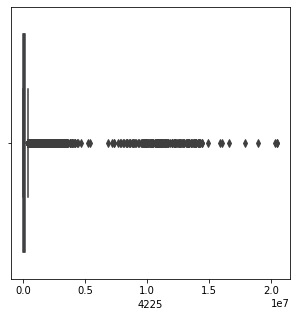

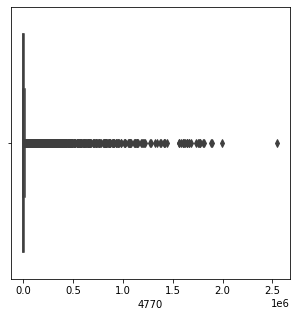

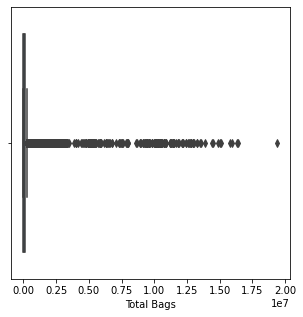

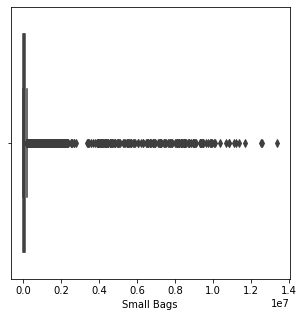

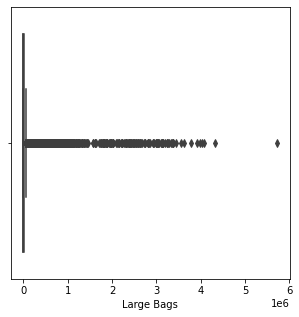

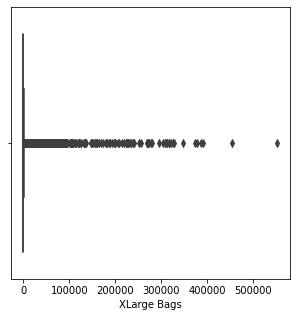

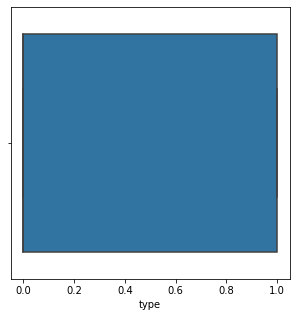

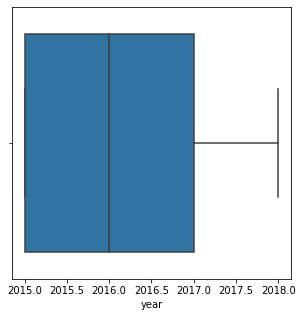

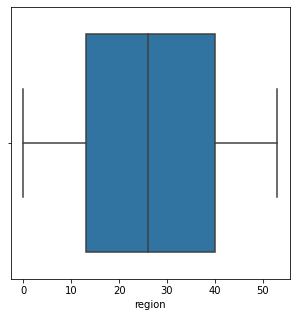

In [172]:
for column in df:
    plt.figure(figsize=(5,5))
    sns.boxplot(x=column,data=df)
    plt.show()

In [173]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year',
       'region'],
      dtype='object')

In [178]:
df['XLarge Bags']=np.where(df['XLarge Bags']>349000, np.mean(df['XLarge Bags']), df['XLarge Bags'])


/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='XLarge Bags'>

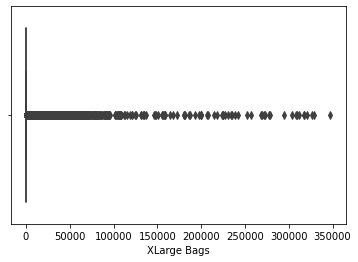

In [179]:
sns.boxplot(df['XLarge Bags'])

As we already see the field descriptions, so for our training we are interested only in fields as below 

In [82]:
# Specifying dependent and independent variables

X = df[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'year', 'region']]
y = df['AveragePrice']
y=np.log1p(y)

In [83]:
X.head()

,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,type,year,region
0,1036.74,54454.85,48.16,8603.62,93.25,0.0,conventional,2015,Albany
1,674.28,44638.81,58.33,9408.07,97.49,0.0,conventional,2015,Albany
2,794.70,109149.67,130.50,8042.21,103.14,0.0,conventional,2015,Albany
3,1132.00,71976.41,72.58,5677.40,133.76,0.0,conventional,2015,Albany
4,941.48,43838.39,75.78,5986.26,197.69,0.0,conventional,2015,Albany


In [84]:
y.head()

0    0.845868
1    0.854415
2    0.657520
3    0.732368
4    0.824175
Name: AveragePrice, dtype: float64

# Labeling the categorical variables

**A dummy variable** is a numeric variable that encodes categorical information.
Dummy variables have two possible values: 0 or 1
<br/>
משתנה דמה

In [85]:
# X_labelled = pd.get_dummies(X[["type","region"]], drop_first = True)
# X_labelled.head()

X = pd.get_dummies(X, prefix=["type","region"], columns=["type","region"], drop_first = True)
X.head()

,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_organic,region_Atlanta,region_BaltimoreWashington,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
0,1036.74,54454.85,48.16,8603.62,93.25,0.0,2015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,674.28,44638.81,58.33,9408.07,97.49,0.0,2015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,794.70,109149.67,130.50,8042.21,103.14,0.0,2015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1132.00,71976.41,72.58,5677.40,133.76,0.0,2015,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,941.48,43838.39,75.78,5986.26,197.69,0.0,2015,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
X.columns

Index(['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags',
       'year', 'type_organic', 'region_Atlanta', 'region_BaltimoreWashington',
       'region_Boise', 'region_Boston', 'region_BuffaloRochester',
       'region_California', 'region_Charlotte', 'region_Chicago',
       'region_CincinnatiDayton', 'region_Columbus', 'region_DallasFtWorth',
       'region_Denver', 'region_Detroit', 'region_GrandRapids',
       'region_GreatLakes', 'region_HarrisburgScranton',
       'region_HartfordSpringfield', 'region_Houston', 'region_Indianapolis',
       'region_Jacksonville', 'region_LasVegas', 'region_LosAngeles',
       'region_Louisville', 'region_MiamiFtLauderdale', 'region_Midsouth',
       'region_Nashville', 'region_NewOrleansMobile', 'region_NewYork',
       'region_Northeast', 'region_NorthernNewEngland', 'region_Orlando',
       'region_Philadelphia', 'region_PhoenixTucson', 'region_Pittsburgh',
       'region_Plains', 'region_Portland', 'region_RaleighGreensboro',
 

# Split into Train and Valid set
# X, y

In [87]:
from sklearn.model_selection import train_test_split 

In [88]:
scaler =MinMaxScaler()
X = scaler.fit_transform(X)

 

In [89]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state = 99)

In [90]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((12774, 61), (5475, 61), (12774,), (5475,))

# Training the Model
## Multiple Linear Regression 

In [91]:
from sklearn.linear_model import LinearRegression

In [93]:
lr = LinearRegression()
lr.fit(X_train,y_train)

print("R2 of Linear Regresson:", lr.score(X_train,y_train) )


R2 of Linear Regresson: 0.5773790751837304


#### bagging the multiple linear regression model

In [94]:
# create decision tree regressor object

# bagging regressor
from sklearn.ensemble import BaggingRegressor
lr_bagging_regressor = BaggingRegressor(base_estimator = lr, n_estimators = 100, random_state = 42)
lr_bagging_regressor.fit(X_train, y_train)
print("R2 of Bagging Regresson:", lr_bagging_regressor.score(X_train,y_train) )
y_pred = lr_bagging_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score  
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, lr_bagging_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=lr_bagging_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=lr_bagging_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)


R2 of Bagging Regresson: 0.5773613205765198
Mean squared error:  0.011867758721778523
R2 score:  0.561168014696219
R2 score of training set:  0.5773613205765198
Accuracy score:  0.561168014696219
Accuracy score of training set:  0.5773613205765198


#### grid search for the linear regression model

In [95]:
# grid search
from sklearn.model_selection import GridSearchCV
# create a dictionary of all values we want to test for n_estimators
param_grid = {'n_estimators': np.arange(10, 200, 10)}
# use gridsearch to test all values for n_estimators
lr_bagging_regressor = BaggingRegressor(base_estimator = lr)
lr_bagging_regressor_gscv = GridSearchCV(lr_bagging_regressor, param_grid, cv=5)
# fit model to data
lr_bagging_regressor_gscv.fit(X_train, y_train)
# check top performing n_estimators value
print(lr_bagging_regressor_gscv.best_params_)
# check mean score for the top performing value of n_estimators
print(lr_bagging_regressor_gscv.best_score_)
# create the best model
lr_bagging_regressor_best = BaggingRegressor(**lr_bagging_regressor_gscv.best_params_)
lr_bagging_regressor_best.fit(X_train, y_train)
print("R2 of Bagging Regresson:", lr_bagging_regressor_best.score(X_train,y_train) )
y_pred = lr_bagging_regressor_best.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, lr_bagging_regressor_best.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=lr_bagging_regressor_best.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=lr_bagging_regressor_best.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between r2 score and accuracy score: ", r2_score-accuracy_score)



{'n_estimators': 60}
0.5727904548739404
R2 of Bagging Regresson: 0.9801201149685029
Mean squared error:  0.0037253998253896827
R2 score:  0.8622465589542154
R2 score of training set:  0.9801201149685029
Accuracy score:  0.8622465589542154
Accuracy score of training set:  0.9801201149685029
Difference between r2 score and accuracy score:  0.0


#### boosting the multiple linear regression model

In [96]:
# boosting regressor
from sklearn.ensemble import AdaBoostRegressor
lr_boosting_regressor = AdaBoostRegressor(base_estimator = lr, n_estimators = 100, random_state = 42)
lr_boosting_regressor.fit(X_train, y_train)
print("R2 of Boosting Regresson:", lr_boosting_regressor.score(X_train,y_train) )
y_pred = lr_boosting_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, lr_boosting_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=lr_boosting_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=lr_boosting_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between r2 score and accuracy score: ", r2_score-accuracy_score)


R2 of Boosting Regresson: 0.5636549768311803
Mean squared error:  0.012204013117369888
R2 score:  0.5487343962309486
R2 score of training set:  0.5636549768311803
Accuracy score:  0.5487343962309486
Accuracy score of training set:  0.5636549768311803
Difference between r2 score and accuracy score:  0.0


#### `as we can see the best model is the bagging model for the linear regression`

## SVR Regressor

In [ ]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf', C=1, gamma= 0.5)   

svr.fit(X_train,y_train)
print(svr.score(X_train,y_train))

0.7352209321641603


#### bagging the SVR model

In [98]:
# bagging regressor
from sklearn.ensemble import BaggingRegressor
svr_bagging_regressor = BaggingRegressor(base_estimator = svr, n_estimators = 100, random_state = 42, n_jobs = -1, oob_score = True, bootstrap = True, max_samples = 0.5)
svr_bagging_regressor.fit(X_train, y_train)
print("R2 of Bagging Regresson:", svr_bagging_regressor.score(X_train,y_train) )
y_pred = svr_bagging_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, svr_bagging_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=svr_bagging_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=svr_bagging_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between r2 score and accuracy score: ", r2_score-accuracy_score)

R2 of Bagging Regresson: 0.6723012263873184
Mean squared error:  0.009482868680209668
R2 score:  0.6493536659390543
R2 score of training set:  0.6723012263873184
Accuracy score:  0.6493536659390543
Accuracy score of training set:  0.6723012263873184
Difference between r2 score and accuracy score:  0.0


#### k fold cross validation for the SVR model

In [99]:
# k-fold cross validation for the svr model
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = svr, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))


Accuracy: 66.66 %
Standard Deviation: 1.81 %


#### boosting the SVR model

In [100]:
# boosting regressor
from sklearn.ensemble import AdaBoostRegressor
svr_boosting_regressor = AdaBoostRegressor(base_estimator = svr, n_estimators = 100, random_state = 42)
svr_boosting_regressor.fit(X_train, y_train)
print("R2 of Boosting Regresson:", svr_boosting_regressor.score(X_train,y_train) )
y_pred = svr_boosting_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, svr_boosting_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=svr_boosting_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=svr_boosting_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between r2 score and accuracy score: ", r2_score-accuracy_score)


R2 of Boosting Regresson: 0.6776413807072121
Mean squared error:  0.009195772392969955
R2 score:  0.6599695738502549
R2 score of training set:  0.6776413807072121
Accuracy score:  0.6599695738502549
Accuracy score of training set:  0.6776413807072121
Difference between r2 score and accuracy score:  0.0


# USE Decision TreeRegressor

In [101]:
dt_reg=DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train,y_train)
print(dt_reg.score(X_train,y_train))

1.0


#### grid search for the Decision TreeRegressor model

In [102]:
# grid search for the decision tree regressor
from sklearn.model_selection import GridSearchCV
parameters = [{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}]
grid_search = GridSearchCV(estimator = dt_reg, param_grid = parameters, scoring = 'r2', cv = 10, n_jobs = -1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
dt_reg_accuracy = grid_search.score(X_train, y_train)
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
dt_reg_parameters = grid_search.best_params_
print("Best Parameters:", best_parameters)
    

Best Accuracy: 70.49 %
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 9}


In [103]:
# creating the decision tree best regresso
dt_reg_best = DecisionTreeRegressor(**dt_reg_parameters, random_state = 42)
dt_reg_best.fit(X_train, y_train)
print("R2 of Decision Tree Regresson:", dt_reg_best.score(X_train,y_train) )
y_pred = dt_reg_best.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score 
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, dt_reg_best.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=dt_reg_best.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=dt_reg_best.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between r2 score and accuracy score: ", r2_score-accuracy_score)


R2 of Decision Tree Regresson: 0.7732993085767867
Mean squared error:  0.008046786253925306
R2 score:  0.7024554281976483
R2 score of training set:  0.7732993085767867
Accuracy score:  0.7024554281976483
Accuracy score of training set:  0.7732993085767867
Difference between r2 score and accuracy score:  0.0


#### boosting the Decision TreeRegressor model

In [105]:
# boosting regressor
from sklearn.ensemble import AdaBoostRegressor
dt_boosting_regressor = AdaBoostRegressor(base_estimator = dt_reg_best, n_estimators = 100, random_state = 42)
dt_boosting_regressor.fit(X_train, y_train)
print("R2 of Boosting Regresson:", dt_boosting_regressor.score(X_train,y_train) )
y_pred = dt_boosting_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, dt_boosting_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=dt_boosting_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=dt_boosting_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between accuracy train score and accuracy score: ", accuracy_score_train-accuracy_score)


R2 of Boosting Regresson: 0.891754418409887
Mean squared error:  0.004894687714050184
R2 score:  0.8190100104531977
R2 score of training set:  0.891754418409887
Accuracy score:  0.8190100104531977
Accuracy score of training set:  0.891754418409887
Difference between accuracy train score and accuracy score:  0.07274440795668935


# knn Regressor

In [106]:
# knn regressor
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train, y_train)
print("R2 of KNN Regresson:", knn_reg.score(X_train,y_train) )
y_pred = knn_reg.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, knn_reg.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=knn_reg.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=knn_reg.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between r2 score and accuracy score
print("Difference between train accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)

R2 of KNN Regresson: 0.9108352980800427
Mean squared error:  0.0038875803936537106
R2 score:  0.8562496371750092
R2 score of training set:  0.9108352980800427
Accuracy score:  0.8562496371750092
Accuracy score of training set:  0.9108352980800427
Difference between train accuracy score and accuracy score:  0.05458566090503347


#### random search for the knn model

In [107]:
# random search for the knn regressor
from sklearn.model_selection import RandomizedSearchCV
parameters = [{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}]
random_search = RandomizedSearchCV(estimator = knn_reg, param_distributions = parameters, scoring = 'r2', cv = 10, n_jobs = -1)
random_search = random_search.fit(X_train, y_train)
best_accuracy = random_search.best_score_
best_parameters = random_search.best_params_
knn_reg_accuracy = random_search.score(X_train, y_train)
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
knn_reg_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)


Best Accuracy: 86.62 %
Best Parameters: {'weights': 'distance', 'n_neighbors': 4, 'algorithm': 'ball_tree'}


#### creating the best knn model

In [108]:
# creating the knn best regressor
knn_reg_best = KNeighborsRegressor(**knn_reg_parameters)
knn_reg_best.fit(X_train, y_train)
print("R2 of KNN Regresson:", knn_reg_best.score(X_train,y_train) )
y_pred = knn_reg_best.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse) 
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, knn_reg_best.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=knn_reg_best.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=knn_reg_best.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score 
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)



R2 of KNN Regresson: 1.0
Mean squared error:  0.0035065914451749623
R2 score:  0.870337397177487
R2 score of training set:  1.0
Accuracy score:  0.870337397177487
Accuracy score of training set:  1.0
Difference between training accuracy score and accuracy score:  0.12966260282251296


#### bagging the knn model

In [109]:
# bagging the knn regressor
from sklearn.ensemble import BaggingRegressor
knn_bagging_regressor = BaggingRegressor(base_estimator = knn_reg_best, n_estimators = 100, random_state = 42)
knn_bagging_regressor.fit(X_train, y_train)
print("R2 of Bagging Regresson:", knn_bagging_regressor.score(X_train,y_train) )
y_pred = knn_bagging_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, knn_bagging_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)  
# calculagte the accuracy of the model
accuracy_score=knn_bagging_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=knn_bagging_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)


R2 of Bagging Regresson: 0.9823093396192354
Mean squared error:  0.003523265729546371
R2 score:  0.8697208351554772
R2 score of training set:  0.9823093396192354
Accuracy score:  0.8697208351554772
Accuracy score of training set:  0.9823093396192354
Difference between training accuracy score and accuracy score:  0.11258850446375823


#### boosting the best knn model

In [110]:
# boosting the knn regressor
from sklearn.ensemble import AdaBoostRegressor
knn_boosting_regressor = AdaBoostRegressor(base_estimator = knn_reg_best, n_estimators = 100, random_state = 42, learning_rate = 0.1, loss = 'linear')
knn_boosting_regressor.fit(X_train, y_train)
print("R2 of Boosting Regresson:", knn_boosting_regressor.score(X_train,y_train) )
y_pred = knn_boosting_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, knn_boosting_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=knn_boosting_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=knn_boosting_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)


R2 of Boosting Regresson: 0.9999784551018649
Mean squared error:  0.003415243188456032
R2 score:  0.8737151652792639
R2 score of training set:  0.9999784551018649
Accuracy score:  0.8737151652792639
Accuracy score of training set:  0.9999784551018649
Difference between training accuracy score and accuracy score:  0.12626328982260104


# gradient boosting regressor

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boosting_regressor = GradientBoostingRegressor(n_estimators = 100, random_state = 42, learning_rate = 0.1, loss = 'ls')
gradient_boosting_regressor.fit(X_train, y_train)
print("R2 of Gradient Boosting Regresson:", gradient_boosting_regressor.score(X_train,y_train) )
y_pred = gradient_boosting_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, gradient_boosting_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=gradient_boosting_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=gradient_boosting_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)


/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


R2 of Gradient Boosting Regresson: 0.6908058226093126
Mean squared error:  0.009037508228074533
R2 score:  0.6658216794846619
R2 score of training set:  0.6908058226093126
Accuracy score:  0.6658216794846619
Accuracy score of training set:  0.6908058226093126
Difference between training accuracy score and accuracy score:  0.024984143124650693


# voting classifier for the best models

In [112]:
# voting classifier 
from sklearn.ensemble import VotingRegressor
best_models_voting_reg=[('knn_reg_best', knn_reg_best),('svr', svr),('dt_reg_best', dt_reg_best),('svr_bagging_regressor', svr_bagging_regressor),('lr_bagging_regressor_best', lr_bagging_regressor_best),('knn_bagging_regressor', knn_bagging_regressor),('knn_boosting_regressor', knn_boosting_regressor),('svr_boosting_regressor', svr_boosting_regressor),('dt_boosting_regressor', dt_boosting_regressor),('lr_boosting_regressor', lr_boosting_regressor),('gradient_boosting_regressor',gradient_boosting_regressor)]
voting_reg = VotingRegressor(estimators = best_models_voting_reg)
voting_reg.fit(X_train, y_train)
print("R2 of Voting Regresson:", voting_reg.score(X_train,y_train) )
y_pred = voting_reg.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, voting_reg.predict(X_train)) 
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model 
accuracy_score=voting_reg.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=voting_reg.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)


/opt/homebrew/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:294: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


R2 of Voting Regresson: 0.8923625848726564
Mean squared error:  0.0049661956082835655
R2 score:  0.816365875875896
R2 score of training set:  0.8923625848726564
Accuracy score:  0.816365875875896
Accuracy score of training set:  0.8923625848726564
Difference between training accuracy score and accuracy score:  0.07599670899676036


# extra tree regressor

In [115]:
#  extra tree regressor
from sklearn.ensemble import ExtraTreesRegressor
extra_tree_regressor = ExtraTreesRegressor(n_estimators = 100, random_state = 42,n_jobs=-1)
extra_tree_regressor.fit(X_train, y_train)
y_pred = extra_tree_regressor.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# r2 score
r2_score = metrics.r2_score(y_valid, y_pred)
print("R2 score: ", r2_score)
# r2 score of training set
r2_score_train = metrics.r2_score(y_train, extra_tree_regressor.predict(X_train))
print("R2 score of training set: ", r2_score_train)
# calculagte the accuracy of the model
accuracy_score=extra_tree_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=extra_tree_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)

Mean squared error:  0.002848299600180926
R2 score:  0.8946789366391799
R2 score of training set:  1.0
Accuracy score:  0.8946789366391799
Accuracy score of training set:  1.0
Difference between training accuracy score and accuracy score:  0.10532106336082014


#### using random search for the extra tree regressor

In [124]:
# # randm search cv for extra tree regressor
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import randint as sp_randint
# param_dist = {"max_depth": [3, None],
#                 "max_features": sp_randint(1, 11),
#                 "min_samples_split": sp_randint(2, 11), 
#                 "bootstrap": [True, False],
#                 "criterion": ["mse", "mae"]}
# n_iter_search = 20
# random_search = RandomizedSearchCV(extra_tree_regressor, param_distributions=param_dist, 
#                                       n_iter=n_iter_search, cv=5, n_jobs=-1)
# random_search.fit(X_train, y_train)
# print("R2 of Random Search CV for Extra Tree Regressor:", random_search.score(X_train,y_train) )
# random_search_best_params=random_search.best_params_
# print("Best parameters for Extra Tree Regressor:", random_search_best_params)

#### boosting the extra tree regressor model

In [125]:
# boosting the extra tree regressor
extra_tree_boosting_regressor = AdaBoostRegressor(base_estimator = extra_tree_regressor, n_estimators = 100, random_state = 42, learning_rate = 0.1)
extra_tree_boosting_regressor.fit(X_train, y_train)
y_pred = extra_tree_boosting_regressor.predict(X_valid) 
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# accuracy score
accuracy_score=extra_tree_boosting_regressor.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=extra_tree_boosting_regressor.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)


Mean squared error:  0.002844868661403618
Accuracy score:  0.894805801846874
Accuracy score of training set:  0.999969572173164
Difference between training accuracy score and accuracy score:  0.10516377032628998


# stacking regressor

In [127]:
# stacking regressor
# random forest regressor
from sklearn.ensemble import RandomForestRegressor
# import linear regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
best_models_stacking_reg=[('knn_reg_best', knn_reg_best),('svr', svr),('dt_reg_best', dt_reg_best),('extra_tree_regressor',extra_tree_regressor),('random_forest',RandomForestRegressor())]
stacking_reg = StackingRegressor(estimators = best_models_stacking_reg, final_estimator = LinearRegression())
stacking_reg.fit(X_train, y_train)
print("R2 of Stacking Regresson:", stacking_reg.score(X_train,y_train) )
y_pred = stacking_reg.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# accuracy score
accuracy_score=stacking_reg.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=stacking_reg.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)

R2 of Stacking Regresson: 0.997650655328854
Mean squared error:  0.0027863491646154008
Accuracy score:  0.8969696667818281
Accuracy score of training set:  0.997650655328854
Difference between training accuracy score and accuracy score:  0.1006809885470259


# xgboost regressor

In [141]:
# create xgb regressor
import xgboost as xgb
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 200,scoring='r2')
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# accuracy score
accuracy_score=xgb_reg.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=xgb_reg.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)
# fpr,tpr,thresholds=metrics.roc_curve(y_valid,y_pred)
# print("AUC score: ", metrics.auc(fpr,tpr))


Mean squared error:  0.008864427077181963
Accuracy score:  0.6722216701522736
Accuracy score of training set:  0.6954415281955941
Difference between training accuracy score and accuracy score:  0.023219858043320496


# catboost regressor

In [143]:
# create catboost regressor
from catboost import CatBoostRegressor
cat_reg = CatBoostRegressor(iterations=200, learning_rate=0.1, depth=5, loss_function='RMSE',silent=True)
cat_reg.fit(X_train, y_train)
y_pred = cat_reg.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# accuracy score
accuracy_score=cat_reg.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=cat_reg.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)

Mean squared error:  0.006755389879308182
Accuracy score:  0.7502071602789026
Accuracy score of training set:  0.7759814910704564
Difference between training accuracy score and accuracy score:  0.02577433079155389


#### using grid search for the catboost regressor

In [144]:
# grid search cv for catboost regressor
from sklearn.model_selection import GridSearchCV
param_grid = {'depth': [4,5,6,7,8],
                'learning_rate' : [0.03, 0.05, 0.07],
                'l2_leaf_reg': [1,4,9],
                'iterations': [100,200,300]}
grid_search = GridSearchCV(cat_reg, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("R2 of Grid Search CV for Catboost Regressor:", grid_search.score(X_train,y_train) )
grid_search_best_params=grid_search.best_params_
print("Best parameters for Catboost Regressor:", grid_search_best_params)


R2 of Grid Search CV for Catboost Regressor: 0.8579465013879355
Best parameters for Catboost Regressor: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.07}


#### best model for the catboost

In [147]:
# create catboost regressor with best parameters
best_cat_reg=CatBoostRegressor(**grid_search_best_params,loss_function='RMSE',silent=True)
best_cat_reg.fit(X_train, y_train)
y_pred = best_cat_reg.predict(X_valid)
# calculating the mean squared error
mse = mean_squared_error(y_valid, y_pred)
print("Mean squared error: ", mse)
# accuracy score
accuracy_score=best_cat_reg.score(X_valid,y_valid)
print("Accuracy score: ", accuracy_score)
accuracy_score_train=best_cat_reg.score(X_train,y_train)
print("Accuracy score of training set: ", accuracy_score_train)
# difference between training accuracy score and accuracy score
print("Difference between training accuracy score and accuracy score: ", accuracy_score_train-accuracy_score)



Mean squared error:  0.00488629873242272
Accuracy score:  0.8193202083219411
Accuracy score of training set:  0.8579465013879355
Difference between training accuracy score and accuracy score:  0.03862629306599441


# saving the models to mongo db

In [114]:
# saving the test data 
def save_x_test_to_mongo(test_to_mongo):
    import pymongo
    import pickle
    data=pickle.dumps(test_to_mongo)
    client = pymongo.MongoClient("mongodb://localhost:27017/")
    db = client["Diabetes"]
    collection = db["test_to_mongo"]
    collection.insert_one({"data":data})

# # # saving the scaler
# import pymongo
# import pickle
# data=pickle.dumps(scaler)
# client = pymongo.MongoClient("mongodb://localhost:27017/")
# db = client["Diabetes"]
# collection = db["scaler"]
# collection.insert_one({"data":data})

# saving the best model
def save_model_to_db(model, client, db, dbconnection, model_name,accuracy,parameters,f1_score,mapk):
    pickled_model = pickle.dumps(model)
    myclient = pymongo.MongoClient(client)
    mydb = myclient[db]
    mycon = mydb[dbconnection]
    # check if model already exists 
    if mycon.count_documents({'model_name':model_name}) == 0:
        # base estimator pickeling if is talked about model with best estimators in the parameters 
        if 'base_estimator'  in parameters:
            base_estimator=pickle.dumps(parameters['base_estimator'])
            parameters.pop('base_estimator')
            parameters['base_estimator']=base_estimator
        elif  'base_estimator__base_estimator' in parameters:
                base_estimator=pickle.dumps(parameters['base_estimator__base_estimator'])
                parameters.pop('base_estimator__base_estimator')
                parameters['base_estimator__base_estimator']=base_estimator
        elif 'estimators' in parameters:
            for param in parameters:
                if 'estimators' in param:
                    for i in range(len(parameters[param])):
                        estimator=pickle.dumps(parameters[param][i])
                        parameters[param][i]=estimator
        mycon.insert_one({'model':pickled_model,"accuracy":accuracy,"parameters":parameters,'mapk':mapk,'f1_score':f1_score,'model_name':model_name,"dbconnection":dbconnection,'model':pickled_model})
    else:
        # check if the model has better accuracy and if so replace it with the new one
        if mycon.find_one({'model_name':model_name})['accuracy'] < accuracy:
            if 'base_estimator'  in parameters:
                base_estimator=pickle.dumps(parameters['base_estimator'])
                parameters.pop('base_estimator')
                parameters['base_estimator']=base_estimator
                mycon.insert_one({'model':pickled_model,"accuracy":accuracy,"parameters":parameters,'mapk':mapk,'f1_score':f1_score,'model_name':model_name,"dbconnection":dbconnection,'model':pickled_model})
                # and delete the old one
                mycon.delete_one({'model_name':model_name})
            elif  'base_estimator__base_estimator' in parameters:
                base_estimator=pickle.dumps(parameters['base_estimator__base_estimator'])
                parameters.pop('base_estimator__base_estimator')
                parameters['base_estimator__base_estimator']=base_estimator
                mycon.insert_one({'model':pickled_model,"accuracy":accuracy,"parameters":parameters,'mapk':mapk,'f1_score':f1_score,'model_name':model_name,"dbconnection":dbconnection,'model':pickled_model})
                # and delete the old one
                mycon.delete_one({'model_name':model_name})   
            elif 'estimators' in parameters:
                for param in parameters:
                    if 'estimators' in param:
                        for i in range(len(parameters[param])):
                            estimator=pickle.dumps(parameters[param][i])
                            parameters[param][i]=estimator
    print("saved",model_name,accuracy)
    
def load_data_from_db(client, db, dbconnection):
    myclient = pymongo.MongoClient(client)
    mydb = myclient[db]
    mycol = mydb[dbconnection]
    records=mycol.find()
    list_cr=list(records)
    for i in list_cr:
        for j in i['parameters']:
            i[j]=i['parameters'][j]
        del i['parameters']
    df=pd.DataFrame(list_cr)
    df['model']=df['model'].apply(lambda x: pickle.loads(x))
    return df


# save models to picle files

In [130]:
def save_the_modell_and_the_info_to_pickle(model_name,model,accuracy,mapk,f1_score,params):
    # save the model to the pickle file
    with open(model_name+'.pkl', 'wb') as file:
        pickle.dump(model, file)
        pickle.dump(accuracy, file)
        pickle.dump(mapk, file)
        pickle.dump(f1_score, file)
        pickle.dump(params, file)
    print('model saved to the pickle file')
   
def load_data_from_pickle_file(model_name):
    with open(model_name+'.pkl', 'rb') as file:
        model=pickle.load(file)
        accuracy=pickle.load(file)
        mapk=pickle.load(file)
        f1_score=pickle.load(file)
        params=pickle.load(file)
    return {'model':model,'accuracy':accuracy,'mapk':mapk,'f1_score':f1_score,'params':params}


# save all the models into a picle file
def save_all_models_to_pickle_file(models):
    with open('models.pickle', 'wb') as f:
        pickle.dump(models, f)
    print('models saved to pickle file')
# load all the models from a picle file
def load_all_models_from_pickle_file():
    with open('models.pickle', 'rb') as f:
        models = pickle.load(f)
    print('models loaded from pickle file')
    return models


In [148]:
# create a list of all the models objects we used
models=[lr_bagging_regressor_best,lr_bagging_regressor,lr_boosting_regressor,dt_reg_best,dt_boosting_regressor,knn_reg_best,knn_bagging_regressor,knn_boosting_regressor,gradient_boosting_regressor,voting_reg,extra_tree_boosting_regressor,stacking_reg,best_cat_reg,xgb_reg]
save_all_models_to_pickle_file(models)
load_all_models_from_pickle_file()

models saved to pickle file
models loaded from pickle file


[BaggingRegressor(n_estimators=60),
 BaggingRegressor(base_estimator=LinearRegression()),
 AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=100,
                   random_state=42),
 DecisionTreeRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=9,
                       random_state=42),
 AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=10,
                                                        min_samples_leaf=2,
                                                        min_samples_split=9,
                                                        random_state=42),
                   n_estimators=100, random_state=42),
 KNeighborsRegressor(algorithm='ball_tree', n_neighbors=4, weights='distance'),
 BaggingRegressor(base_estimator=KNeighborsRegressor(algorithm='ball_tree',
                                                     n_neighbors=4,
                                                     weights='distance'),
                  n_estimators=1